## Hyper Parameter Tuning:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import urbanNoises

In [2]:
with open('Data/pickles/MelFeatures.pickle', 'rb') as file:
    mel=pickle.load(file)
    
with open('Data/pickles/MFCCFeatures.pickle', 'rb') as file:
    MFCC=pickle.load(file)

with open('Data/pickles/ChromaFeatures.pickle', 'rb') as file:
    chroma=pickle.load(file)

with open('Data/pickles/tonnetzFeatures.pickle', 'rb') as file:
    tonnetz=pickle.load(file)

info=pd.read_csv('Data/UrbanSound8K.csv')

features=np.concatenate((mel, MFCC, chroma, tonnetz),axis=1)

features=pd.DataFrame(features)

info = pd.concat([info, features], axis=1) 

x1, y1 = info.shape

info = info.dropna() #remove any features that were not succesfully calculated.

x2, y2 = info.shape

print('{} Rows were dropped and {} columns were dropped'.format(x1-x2,y1-y2))    

labels=info['class'].unique()

0 Rows were dropped and 0 columns were dropped


In [3]:
info.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,0,1,...,176,177,178,179,180,181,182,183,184,185
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,0.000027,0.000222,...,0.914163,0.788859,0.482100,0.497833,0.021190,-0.010982,-0.133131,0.094218,-0.012384,0.009034
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,0.049700,0.049527,...,0.617903,0.675770,0.693920,0.684928,-0.006520,0.004458,-0.008590,-0.001745,-0.004053,-0.000320
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,0.030849,0.028020,...,0.636775,0.646543,0.723038,0.750797,-0.013711,0.031615,-0.050797,0.020023,0.011620,0.009686
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,0.026511,0.032827,...,0.626030,0.636564,0.666254,0.679418,0.001021,0.021068,-0.009772,0.007726,0.004001,0.006359
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,0.061541,0.040469,...,0.595789,0.617314,0.691961,0.827252,-0.037152,0.074556,-0.073728,0.125956,0.042143,0.042983


## SVM Hyper-parameter tuning:

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

C_poss=[0.001,0.1,1,10]
kernel_poss=['linear', 'poly', 'rbf', 'sigmoid']
gamma_poss=[0.001,0.1,1,10]



performance=np.zeros(10) #performance of algorithm for each test fold
Params=[] #optimal parameters used for each test fold

for testfold in np.arange(1,11):
    print('Working on testfold {}'.format(testfold))
    #fold i is the test fold here.
    #We now perform hyper-parameter tuning by doing cross-validation
    #for each hyper-parameter candidate.
       
    info_test=info[info['fold']==testfold]
    
    info_train=info[info['fold']!=testfold]
    
    X_train=info_train.iloc[:,8:]
    X_test=info_test.iloc[:,8:]
                    
    y_train=info_train.iloc[:,7]
    y_test=info_test.iloc[:,7]    
    
       
    optimalScore=0 #score best hyper-parameter combination achieves
    HyperParams=[] #optimal hyper parameter values 
    
    for C in C_poss:
        for kernel in kernel_poss:
            for gamma in gamma_poss:
                score=[]
                for subfold in info_train['fold'].unique():
                    sub_test=info[(info['fold']==subfold) & (info['fold']!=testfold)]
                    sub_test=sub_test.sample(n=100)
                    
                    sub_train=info[(info['fold']!=subfold) & (info['fold']!=testfold)]
                    sub_train=sub_train.sample(n=800)
                    
                    X_sub_train=sub_train.iloc[:,8:].values
                    X_sub_test=sub_test.iloc[:,8:].values
                    
                    y_sub_train=sub_train.iloc[:,7].values
                    y_sub_test=sub_test.iloc[:,7].values
                    
                    
                    if kernel=='linear':
                        pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                                       ('classifier',SVC(C=C,kernel=kernel))])

                    else:
                        pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                                       ('classifier',SVC(C=C,kernel=kernel,gamma=gamma))])
                    
                    pipe.fit(X_sub_train,y_sub_train)
                    
                    score.append(pipe.score(X_sub_test,y_sub_test))
                
                score=np.sum(score)/len(score)
                if score>optimalScore:
                    optimalScore=score
                    HyperParams=[C,kernel,gamma]
    
    if HyperParams[1]=='linear':
        pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',SVC(C=HyperParams[0],kernel='linear'))])
    else:
         pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',SVC(C=HyperParams[0],
                                         kernel=HyperParams[1],
                                         gamma=HyperParams[2]))])
    pipe.fit(X_train,y_train)
    performance[testfold-1]=pipe.score(X_test,y_test)
    Params.append(HyperParams)

                    
                   
                
                
print('SVM performs with {} accuracy on average'.format(np.mean(performance)))                   


Working on testfold 1
Working on testfold 2
Working on testfold 3
Working on testfold 4
Working on testfold 5
Working on testfold 6
Working on testfold 7
Working on testfold 8
Working on testfold 9
Working on testfold 10
SVM performs with 0.5913225197535594 accuracy on average


In [5]:
performance

array([0.59106529, 0.56081081, 0.57513514, 0.58383838, 0.65918803,
       0.56500608, 0.63603819, 0.5707196 , 0.59436275, 0.57706093])

Normalized confusion matrix
[[0.63       0.14       0.         0.08       0.01       0.06
  0.         0.06       0.         0.02      ]
 [0.08       0.62       0.         0.01       0.11       0.
  0.02       0.04       0.06       0.06      ]
 [0.01020408 0.03061224 0.75510204 0.02040816 0.09183673 0.
  0.01020408 0.02040816 0.         0.06122449]
 [0.03       0.34       0.         0.37       0.01       0.
  0.05       0.1        0.         0.1       ]
 [0.15       0.02       0.02       0.04       0.68       0.02
  0.04       0.01       0.         0.02      ]
 [0.025      0.025      0.         0.         0.         0.95
  0.         0.         0.         0.        ]
 [0.33802817 0.01408451 0.         0.01408451 0.04225352 0.
  0.57746479 0.01408451 0.         0.        ]
 [0.03738318 0.18691589 0.         0.17757009 0.01869159 0.01869159
  0.         0.5046729  0.03738318 0.01869159]
 [0.         0.01666667 0.05       0.01666667 0.05833333 0.
  0.         0.05833333 0.63333333 0.16666

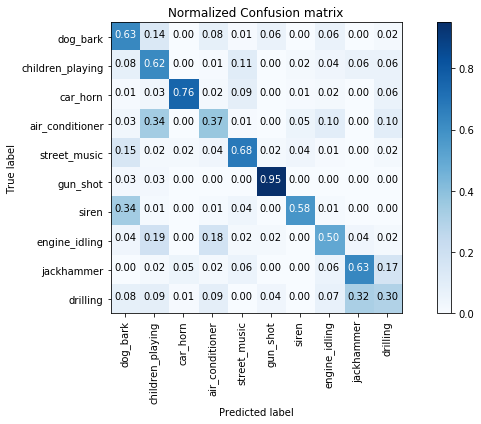

In [6]:
testfold=np.argmax(performance)+1
bestparams=Params[testfold-1]

info_test=info[info['fold']==testfold]
    
info_train=info[info['fold']!=testfold]
    
X_train=info_train.iloc[:,8:]
X_test=info_test.iloc[:,8:]
                    
y_train=info_train.iloc[:,7]
y_test=info_test.iloc[:,7]  

if HyperParams[1]=='linear':
    pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',SVC(C=bestparams[0],kernel='linear'))])
else:
    pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',SVC(C=bestparams[0],
                                         kernel=bestparams[1],
                                         gamma=bestparams[2]))])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

fig=urbanNoises.plot_confusion_matrix(y_test, y_pred,labels)
fig.tight_layout()
fig.savefig('plots/SVMPerformance.png')

## KNN Hyper-Parameter Tuning:

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

n_poss=[1,3,5,9,21,35,71,100,111]



performance=np.zeros(10) #performance of algorithm for each test fold
Params=[] #optimal parameters used for each test fold

for testfold in np.arange(1,11):
    print('Working on testfold {}'.format(testfold))
    #fold i is the test fold here.
    #We now perform hyper-parameter tuning by doing cross-validation
    #for each hyper-parameter candidate.
       
    info_test=info[info['fold']==testfold]
    
    info_train=info[info['fold']!=testfold]
    
    X_train=info_train.iloc[:,8:]
    X_test=info_test.iloc[:,8:]
                    
    y_train=info_train.iloc[:,7]
    y_test=info_test.iloc[:,7]    
    
       
    optimalScore=0 #score best hyper-parameter combination achieves
    HyperParams=[] #optimal hyper parameter values 
    
    for n in n_poss:
        score=[]
        for subfold in info_train['fold'].unique():
            sub_test=info[(info['fold']==subfold) & (info['fold']!=testfold)]
            sub_test=sub_test.sample(n=100)
                    
            sub_train=info[(info['fold']!=subfold) & (info['fold']!=testfold)]
            sub_train=sub_train.sample(n=800)
                    
            X_sub_train=sub_train.iloc[:,8:].values
            X_sub_test=sub_test.iloc[:,8:].values
                    
            y_sub_train=sub_train.iloc[:,7].values
            y_sub_test=sub_test.iloc[:,7].values
                    



            pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                               ('classifier',KNeighborsClassifier(n_neighbors=n))])
                    
            pipe.fit(X_sub_train,y_sub_train)
                    
            score.append(pipe.score(X_sub_test,y_sub_test))
                
        score=np.sum(score)/len(score)
        if score>optimalScore:
            optimalScore=score
            HyperParams=n

    
    pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                   ('classifier',KNeighborsClassifier(n_neighbors=HyperParams))])
    pipe.fit(X_train,y_train)
    performance[testfold-1]=pipe.score(X_test,y_test)
    Params.append(HyperParams)
    
                    
                   
                
                
print('KNN performs with {} accuracy on average'.format(np.mean(performance)))                   


Working on testfold 1
Working on testfold 2
Working on testfold 3
Working on testfold 4
Working on testfold 5
Working on testfold 6
Working on testfold 7
Working on testfold 8
Working on testfold 9
Working on testfold 10
KNN performs with 0.4963757746286806 accuracy on average


Normalized confusion matrix
[[0.57       0.26       0.01       0.08       0.06       0.
  0.01       0.         0.         0.01      ]
 [0.08       0.81       0.         0.         0.01       0.
  0.09       0.         0.         0.01      ]
 [0.         0.09375    0.71875    0.         0.09375    0.
  0.09375    0.         0.         0.        ]
 [0.19       0.33       0.         0.15       0.14       0.
  0.03       0.         0.09       0.07      ]
 [0.03       0.37       0.         0.02       0.4        0.
  0.18       0.         0.         0.        ]
 [0.16129032 0.09677419 0.         0.         0.         0.61290323
  0.12903226 0.         0.         0.        ]
 [0.03658537 0.04878049 0.         0.         0.         0.
  0.91463415 0.         0.         0.        ]
 [0.02247191 0.1011236  0.02247191 0.15730337 0.02247191 0.02247191
  0.         0.64044944 0.01123596 0.        ]
 [0.         0.09756098 0.         0.         0.02439024 0.02439024
  0.         0.01219512 0.780487

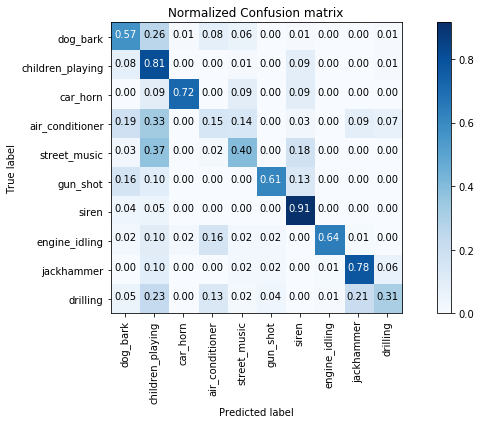

In [8]:
testfold=np.argmax(performance)+1
bestparams=Params[testfold-1]

info_test=info[info['fold']==testfold]
    
info_train=info[info['fold']!=testfold]
    
X_train=info_train.iloc[:,8:]
X_test=info_test.iloc[:,8:]
                    
y_train=info_train.iloc[:,7]
y_test=info_test.iloc[:,7]  



pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',KNeighborsClassifier(n_neighbors=bestparams))])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

fig=urbanNoises.plot_confusion_matrix(y_test, y_pred,labels)
fig.tight_layout()
fig.savefig('plots/KNNPerformance.png')

## Random Forest Hyper-Parameter Tuning:

In [9]:
from sklearn.ensemble import RandomForestClassifier


n_poss=[10,50,100]
features_poss=[10,15,20,50]




performance=np.zeros(10) #performance of algorithm for each test fold
Params=[] #optimal parameters used for each test fold

for testfold in np.arange(1,11):
    print('Working on testfold {}'.format(testfold))
    #fold i is the test fold here.
    #We now perform hyper-parameter tuning by doing cross-validation
    #for each hyper-parameter candidate.
       
    info_test=info[info['fold']==testfold]
    
    info_train=info[info['fold']!=testfold]
    
    X_train=info_train.iloc[:,8:]
    X_test=info_test.iloc[:,8:]
                    
    y_train=info_train.iloc[:,7]
    y_test=info_test.iloc[:,7]    
    
       
    optimalScore=0 #score best hyper-parameter combination achieves
    HyperParams=[] #optimal hyper parameter values 
    

    for n in n_poss:
        for f in features_poss:
            score=[]
            for subfold in info_train['fold'].unique():
                sub_test=info[(info['fold']==subfold) & (info['fold']!=testfold)]
                sub_test=sub_test.sample(n=100)
                    
                sub_train=info[(info['fold']!=subfold) & (info['fold']!=testfold)]
                sub_train=sub_train.sample(n=800)
                    
                X_sub_train=sub_train.iloc[:,8:].values
                X_sub_test=sub_test.iloc[:,8:].values
                    
                y_sub_train=sub_train.iloc[:,7].values
                y_sub_test=sub_test.iloc[:,7].values
                

                model=RandomForestClassifier(n_estimators=n,max_features=f)    
                model.fit(X_sub_train,y_sub_train)
                    
                score.append(model.score(X_sub_test,y_sub_test))
                
            score=np.sum(score)/len(score)
            if score>optimalScore:
                optimalScore=score
                HyperParams=[n,f]
    
    model=RandomForestClassifier(n_estimators=HyperParams[0],max_features=HyperParams[1])
    model.fit(X_train,y_train)
    performance[testfold-1]=model.score(X_test,y_test)
    Params.append(HyperParams)
    
                    
                   
                
                
print('Random Forest performs with {} accuracy on average'.format(np.mean(performance)))                   


Working on testfold 1
Working on testfold 2
Working on testfold 3
Working on testfold 4
Working on testfold 5
Working on testfold 6
Working on testfold 7
Working on testfold 8
Working on testfold 9
Working on testfold 10
Random Forest performs with 0.5657695365483562 accuracy on average


Normalized confusion matrix
[[0.79       0.15       0.         0.01       0.01       0.
  0.03       0.01       0.         0.        ]
 [0.02       0.74       0.         0.03       0.09       0.
  0.         0.12       0.         0.        ]
 [0.07142857 0.32142857 0.35714286 0.         0.10714286 0.
  0.03571429 0.03571429 0.07142857 0.        ]
 [0.02       0.11       0.         0.72       0.04       0.
  0.01       0.09       0.01       0.        ]
 [0.         0.07       0.01       0.         0.74       0.
  0.05       0.         0.01       0.12      ]
 [0.01960784 0.         0.         0.         0.         0.8627451
  0.         0.03921569 0.         0.07843137]
 [0.07792208 0.15584416 0.01298701 0.06493506 0.16883117 0.
  0.41558442 0.         0.1038961  0.        ]
 [0.08490566 0.20754717 0.01886792 0.11320755 0.10377358 0.
  0.         0.40566038 0.06603774 0.        ]
 [0.         0.         0.         0.02631579 0.05263158 0.
  0.         0.         0.59210526 0.32894737]
 [

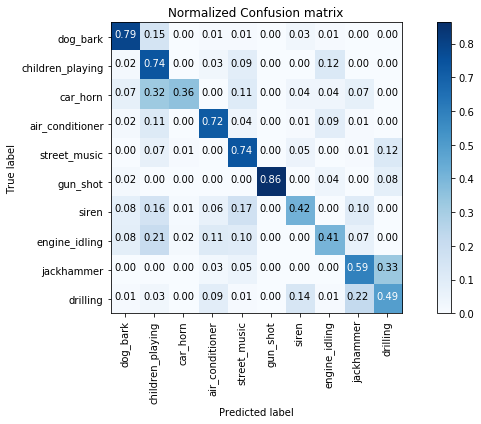

In [10]:
testfold=np.argmax(performance)+1
bestparams=Params[testfold-1]

info_test=info[info['fold']==testfold]
    
info_train=info[info['fold']!=testfold]
    
X_train=info_train.iloc[:,8:]
X_test=info_test.iloc[:,8:]
                    
y_train=info_train.iloc[:,7]
y_test=info_test.iloc[:,7]  



model=RandomForestClassifier(n_estimators=bestparams[0],max_features=bestparams[1])
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

fig=urbanNoises.plot_confusion_matrix(y_test, y_pred,labels)
fig.tight_layout()
fig.savefig('plots/RandomForestPerformance.png')

## Neural Net Hyper-Parameter Tuning:

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

LayerSize_poss=[186,200,250]
AFunc_poss=['logistic', 'tanh', 'relu']
Solver_poss=['adam']



performance=np.zeros(10) #performance of algorithm for each test fold
Params=[] #optimal parameters used for each test fold

for testfold in np.arange(1,11):
    print('Working on testfold {}'.format(testfold))
    #fold i is the test fold here.
    #We now perform hyper-parameter tuning by doing cross-validation
    #for each hyper-parameter candidate.
       
    info_test=info[info['fold']==testfold]
    
    info_train=info[info['fold']!=testfold]
    
    X_train=info_train.iloc[:,8:]
    X_test=info_test.iloc[:,8:]
                    
    y_train=info_train.iloc[:,7]
    y_test=info_test.iloc[:,7]    
    
       
    optimalScore=0 #score best hyper-parameter combination achieves
    HyperParams=[] #optimal hyper parameter values 
    
    for s in LayerSize_poss:
        for afunc in AFunc_poss:
            for solver in Solver_poss:
                score=[]
                for subfold in info_train['fold'].unique():
                    sub_test=info[(info['fold']==subfold) & (info['fold']!=testfold)]
                    sub_test=sub_test.sample(n=100)
                    
                    sub_train=info[(info['fold']!=subfold) & (info['fold']!=testfold)]
                    sub_train=sub_train.sample(n=800)
                    
                    X_sub_train=sub_train.iloc[:,8:].values
                    X_sub_test=sub_test.iloc[:,8:].values
                    
                    y_sub_train=sub_train.iloc[:,7].values
                    y_sub_test=sub_test.iloc[:,7].values
                    
                    

                        
                    pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                                       ('classifier',MLPClassifier(hidden_layer_sizes=(s,s+186,s+s+186)
                                                                   ,activation=afunc))])
                    
                    pipe.fit(X_sub_train,y_sub_train)
                    
                    score.append(pipe.score(X_sub_test,y_sub_test))
                
                score=np.sum(score)/len(score)
                if score>optimalScore:
                    optimalScore=score
                    HyperParams=[s,afunc]
    

    pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',
                        MLPClassifier(hidden_layer_sizes=(HyperParams[0],HyperParams[0]+186,2*HyperParams[0]+186),
                                                   activation=HyperParams[1]))])
    pipe.fit(X_train,y_train)
    performance[testfold-1]=pipe.score(X_test,y_test)
    Params.append(HyperParams)
    
                    
                   
                
                
print('MLP performs with {} accuracy on average'.format(np.mean(performance)))                   


Working on testfold 1
Working on testfold 2
Working on testfold 3
Working on testfold 4
Working on testfold 5
Working on testfold 6
Working on testfold 7
Working on testfold 8
Working on testfold 9
Working on testfold 10
MLP performs with 0.5612064440016786 accuracy on average


Normalized confusion matrix
[[0.69       0.05       0.         0.05       0.08       0.03
  0.02       0.02       0.         0.06      ]
 [0.07       0.84       0.         0.         0.         0.01
  0.04       0.03       0.01       0.        ]
 [0.03125    0.         0.78125    0.         0.09375    0.
  0.         0.09375    0.         0.        ]
 [0.2        0.09       0.08       0.11       0.18       0.
  0.         0.01       0.01       0.32      ]
 [0.02       0.23       0.         0.01       0.69       0.
  0.05       0.         0.         0.        ]
 [0.32258065 0.         0.         0.03225806 0.         0.64516129
  0.         0.         0.         0.        ]
 [0.01219512 0.         0.         0.         0.         0.
  0.98780488 0.         0.         0.        ]
 [0.         0.         0.05617978 0.19101124 0.04494382 0.
  0.         0.68539326 0.02247191 0.        ]
 [0.         0.         0.         0.02439024 0.         0.
  0.         0.         0.87804878 0.0975609

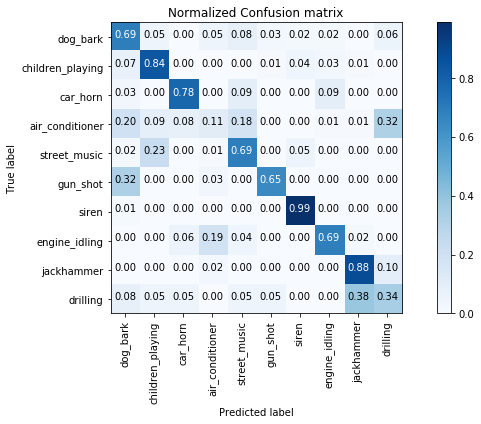

In [12]:
testfold=np.argmax(performance)+1
bestparams=Params[testfold-1]

info_test=info[info['fold']==testfold]
    
info_train=info[info['fold']!=testfold]
    
X_train=info_train.iloc[:,8:]
X_test=info_test.iloc[:,8:]
                    
y_train=info_train.iloc[:,7]
y_test=info_test.iloc[:,7]  



pipe=Pipeline([('scaler',MinMaxScaler(feature_range=(-1,1))),
                       ('classifier',
                        MLPClassifier(hidden_layer_sizes=(bestparams[0],bestparams[0]+186,2*bestparams[0]+186),
                                     activation=bestparams[1]))])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)

fig=urbanNoises.plot_confusion_matrix(y_test, y_pred,labels)
fig.tight_layout()
fig.savefig('plots/MLPPerformance.png')